In [30]:
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import layers, models
from keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization, Dropout, \
    Attention
from keras import *
from keras.applications import MobileNet
from keras.applications import VGG16
from keras.applications.resnet import ResNet50
from keras import backend as K
from keras.layers import Layer
import keras.layers as kl
import pandas as pd
from keras.applications import EfficientNetB0
import keras.applications
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, cohen_kappa_score , ConfusionMatrixDisplay , confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import pickle
import tensorflow_addons as tfa
from sklearn import metrics
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.models import load_model
import os
import glob
from tensorflow.keras.preprocessing import image

In [23]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name="f1_score", **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name="f1", initializer="zeros")
        self.precision_fn = tf.keras.metrics.Precision()
        self.recall_fn = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        self.f1.assign(2 * ((p * r) / (p + r + 1e-10)))

    def result(self):
        return self.f1

    def reset_state(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)

In [24]:
class_mode = "binary"
batch_size = 1
target_categories = ['XR_ELBOW', 'XR_HUMERUS', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_HUMERUS']
target_category = 'XR_HUMERUS'

In [25]:
mura_location = "C:/Users/raouf/Desktop/pfe/"
test_dir = "C:/Users/raouf/Desktop/pfe/MURA-v1.1/valid_image_paths.csv"
def load_data(file, part):
    train_data = pd.read_csv(file)
    train_data = train_data.rename(columns={train_data.columns[0]: 'image_path'})
    train_data['label'] = 2
    string_to_add = mura_location
    train_data['image_path'] = string_to_add + train_data['image_path'].astype(str)
    for index, row in train_data.iterrows():
        if 'positive' in str(row['image_path']).lower():
            train_data.at[index, 'label'] = "positive"
        else:
            train_data.at[index, 'label'] = "negative"

    if part == 0:
        pass
    else:
        train_data = train_data[train_data['image_path'].str.contains(part)]
    return train_data

In [26]:
df_test = load_data(test_dir,target_category)
df_test

C:\Users\raouf\AppData\Local\Temp\ipykernel_91164\850539721.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'positive' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.at[index, 'label'] = "positive"


,image_path,label
0,C:/Users/raouf/Desktop/pfe/MURA-v1.1/valid/XR_...,positive
1,C:/Users/raouf/Desktop/pfe/MURA-v1.1/valid/XR_...,positive
2,C:/Users/raouf/Desktop/pfe/MURA-v1.1/valid/XR_...,positive
3,C:/Users/raouf/Desktop/pfe/MURA-v1.1/valid/XR_...,positive
4,C:/Users/raouf/Desktop/pfe/MURA-v1.1/valid/XR_...,positive
...,...,...
653,C:/Users/raouf/Desktop/pfe/MURA-v1.1/valid/XR_...,negative
654,C:/Users/raouf/Desktop/pfe/MURA-v1.1/valid/XR_...,negative
655,C:/Users/raouf/Desktop/pfe/MURA-v1.1/valid/XR_...,negative
656,C:/Users/raouf/Desktop/pfe/MURA-v1.1/valid/XR_...,negative


VGG16

In [27]:
model_path = "C:/Users/raouf/Desktop/pfe/history/final/vgg/XR_HUMERUS/finetuned_VGG_XR_HUMERUS.keras"
model = load_model(model_path , custom_objects={'F1Score': F1Score})

test_datagen = image.ImageDataGenerator(preprocessing_function=vgg16_preprocess_input)
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  directory=None,
                                                  x_col='image_path',
                                                  y_col='label',
                                                  target_size=(224,224),
                                                  batch_size=batch_size,
                                                  class_mode=class_mode,
                                                  shuffle=False
                                                  )



predictions = model.predict(test_generator)

#predicted_classes = np.argmax(predictions, axis=1)
predicted_classes = (predictions > 0.5).astype(int)


true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)




cm = confusion_matrix(true_classes, predicted_classes)
TN, FP, FN, TP = cm.ravel()
conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

labels = ['Negative','Positive']

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# Increase the font size of the numbers inside the matrix
for texts in disp.text_.ravel():
    texts.set_fontsize(16)
plt.show()

Found 658 validated image filenames belonging to 2 classes.


DenseNet

In [ ]:
model_path = "C:/Users/raouf/Desktop/pfe/history/final/densenet/XR_HUMERUS/finetuned_DenseNet_XR_HUMERUS.keras"
model = load_model(model_path , custom_objects={'F1Score': F1Score})

test_datagen = image.ImageDataGenerator(preprocessing_function=densenet_preprocess_input)
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  directory=None,
                                                  x_col='image_path',
                                                  y_col='label',
                                                  target_size=(224,224),
                                                  batch_size=batch_size,
                                                  class_mode=class_mode,
                                                  shuffle=False
                                                  )



predictions = model.predict(test_generator)

#predicted_classes = np.argmax(predictions, axis=1)
predicted_classes = (predictions > 0.5).astype(int)


true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)




cm = confusion_matrix(true_classes, predicted_classes)
TN, FP, FN, TP = cm.ravel()
conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

labels = ['Negative','Positive']

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# Increase the font size of the numbers inside the matrix
for texts in disp.text_.ravel():
    texts.set_fontsize(16)
plt.show()

ResNet

Found 658 validated image filenames belonging to 2 classes.
658/658 [==============================] - 7s 10ms/step
              precision    recall  f1-score   support

    negative       0.81      0.94      0.87       364
    positive       0.91      0.73      0.81       294

    accuracy                           0.84       658
   macro avg       0.86      0.83      0.84       658
weighted avg       0.85      0.84      0.84       658



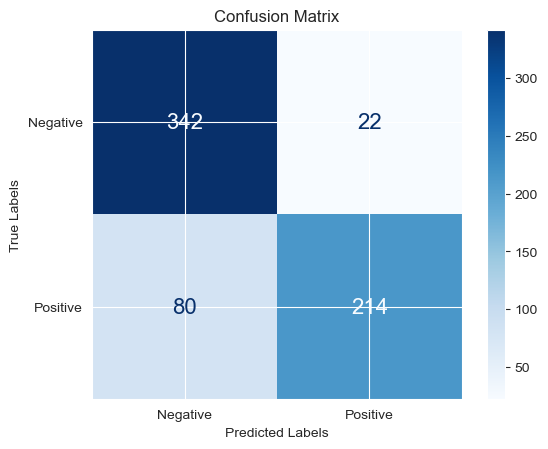

In [32]:
model_path = "C:/Users/raouf/Desktop/pfe/history/final/resnet/XR_HUMERUS/finetuned_ResNet_XR_HUMERUS.keras"
model = load_model(model_path , custom_objects={'F1Score': F1Score})

test_datagen = image.ImageDataGenerator(preprocessing_function=resnet50_preprocess_input)
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  directory=None,
                                                  x_col='image_path',
                                                  y_col='label',
                                                  target_size=(224,224),
                                                  batch_size=batch_size,
                                                  class_mode=class_mode,
                                                  shuffle=False
                                                  )



predictions = model.predict(test_generator)

#predicted_classes = np.argmax(predictions, axis=1)
predicted_classes = (predictions > 0.5).astype(int)


true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)




cm = confusion_matrix(true_classes, predicted_classes)
TN, FP, FN, TP = cm.ravel()
conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

labels = ['Negative','Positive']

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# Increase the font size of the numbers inside the matrix
for texts in disp.text_.ravel():
    texts.set_fontsize(16)
plt.show()

DenseNet+Resnet

In [ ]:
model_path = "C:/Users/raouf/Desktop/pfe/history/new_arch/dense_res/XR_HUMERUS/dense_res_XR_HUMERUS.keras"
model = load_model(model_path , custom_objects={'F1Score': F1Score})

test_datagen = image.ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  directory=None,
                                                  x_col='image_path',
                                                  y_col='label',
                                                  target_size=(224,224),
                                                  batch_size=batch_size,
                                                  class_mode=class_mode,
                                                  shuffle=False
                                                  )



predictions = model.predict(test_generator)

#predicted_classes = np.argmax(predictions, axis=1)
predicted_classes = (predictions > 0.5).astype(int)


true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)




cm = confusion_matrix(true_classes, predicted_classes)
TN, FP, FN, TP = cm.ravel()
conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

labels = ['Negative','Positive']

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# Increase the font size of the numbers inside the matrix
for texts in disp.text_.ravel():
    texts.set_fontsize(16)
plt.show()

DenseNet+VGG16

In [ ]:
model_path = "C:/Users/raouf/Desktop/pfe/history/new_arch/dense_vgg/XR_HUMERUS/dense_vgg_XR_HUMERUS.keras"
model = load_model(model_path , custom_objects={'F1Score': F1Score})

test_datagen = image.ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  directory=None,
                                                  x_col='image_path',
                                                  y_col='label',
                                                  target_size=(224,224),
                                                  batch_size=batch_size,
                                                  class_mode=class_mode,
                                                  shuffle=False
                                                  )



predictions = model.predict(test_generator)

#predicted_classes = np.argmax(predictions, axis=1)
predicted_classes = (predictions > 0.5).astype(int)


true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)




cm = confusion_matrix(true_classes, predicted_classes)
TN, FP, FN, TP = cm.ravel()
conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

labels = ['Negative','Positive']

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# Increase the font size of the numbers inside the matrix
for texts in disp.text_.ravel():
    texts.set_fontsize(16)
plt.show()

ResNet+VGG16

In [ ]:
model_path = "C:/Users/raouf/Desktop/pfe/history/new_arch/res_vgg/XR_HUMERUS/res_vgg_XR_HUMERUS.keras"
model = load_model(model_path , custom_objects={'F1Score': F1Score})

test_datagen = image.ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  directory=None,
                                                  x_col='image_path',
                                                  y_col='label',
                                                  target_size=(224,224),
                                                  batch_size=batch_size,
                                                  class_mode=class_mode,
                                                  shuffle=False
                                                  )



predictions = model.predict(test_generator)

#predicted_classes = np.argmax(predictions, axis=1)
predicted_classes = (predictions > 0.5).astype(int)


true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)




cm = confusion_matrix(true_classes, predicted_classes)
TN, FP, FN, TP = cm.ravel()
conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

labels = ['Negative','Positive']

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# Increase the font size of the numbers inside the matrix
for texts in disp.text_.ravel():
    texts.set_fontsize(16)
plt.show()

All Ensemble

In [ ]:
model_path = "C:/Users/raouf/Desktop/pfe/history/new_arch/ensemble_all/XR_HUMERUS/ensemble_all_XR_HUMERUS.keras"
model = load_model(model_path , custom_objects={'F1Score': F1Score})

test_datagen = image.ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  directory=None,
                                                  x_col='image_path',
                                                  y_col='label',
                                                  target_size=(224,224),
                                                  batch_size=batch_size,
                                                  class_mode=class_mode,
                                                  shuffle=False
                                                  )



predictions = model.predict(test_generator)

#predicted_classes = np.argmax(predictions, axis=1)
predicted_classes = (predictions > 0.5).astype(int)


true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)




cm = confusion_matrix(true_classes, predicted_classes)
TN, FP, FN, TP = cm.ravel()
conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

labels = ['Negative','Positive']

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')

# Customize the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# Increase the font size of the numbers inside the matrix
for texts in disp.text_.ravel():
    texts.set_fontsize(16)
plt.show()

Average Voting